# CausalML Lecture 5: Heterogeneous Treatment Effect

"The average causal effect T is an _average_ and as such enjoys all the advantages and disadvantages of averages." – P. W. Holland

**Giorgio Coppola**  
**Xiaohan Wu**

---

## Setup Instructions

To replicate this environment and run this notebook with the exact same package versions using poetry like in Lecture 1:

1. **Install dependencies**:
   ```bash
   poetry install
   ```
   This will create a virtual environment and install all dependencies specified in `pyproject.toml`. Learn more about [dependency management](https://python-poetry.org/docs/dependency-specification/).

2. **Create and install the Jupyter kernel**:
   ```bash
   poetry run python -m ipykernel install --user --name=lecture-5-env --display-name="CausalML Lecture 5"
   ```
   The `poetry run` command executes commands within the Poetry virtual environment. See [Poetry environment management](https://python-poetry.org/docs/managing-environments/).

3. **Start Jupyter**:
   ```bash
   poetry run jupyter notebook
   ```

4. **Select the kernel**: In Jupyter, go to Kernel → Change Kernel → "CausalML Lecture 5"

For more information about Poetry and its features, visit the [official Poetry documentation](https://python-poetry.org/docs/).

---

## Quick recap form Lecture 5 and previous  

#### Until now, we **focused on the ATE** in experimental or nonrandomized observational settings, using **global information!**  

For this, **modeling (including ML) helps:** we can adjust for pre-treatment covariates, balance with weights, or do both. These approaches help because they **exploit covariates information to approximate missing counterfactuals** and to implement the assumption of conditional ignorability when it’s plausible.  

- In **experimental settings,** ignorability holds by design; covariate adjustment mainly improves precision (and can mitigate sample imbalance and noncompliance), while weighting rebalances covariates to address observed selection bias when randomization fails (if we have overlap). Doubly robust estimators combine outcome and treatment models and are consistent if either is correctly specified.  

- In **observational settings,** identification relies on **conditional ignorability** given selected pre-treatment covariates (plus overlap and SUTVA). Models and weights (or both), if they are correctly specified, can help replace the assumption of independence with a less stringent conditional version, yielding to a consistent ATE.  

#### **With HTE, this is harder:** we need local information, but **local information is scarce!**   

We want to estimate a **causal effect that vary across units**. Problem: we cannot make causal claims about specific individuals with certainty!  

When estimating HTE, we are interested in **ITE or CATE conditional on groups defined by X**. We cannot estimate ITE, but CATE is a compromise. However, as X-defined groups get finer, we can lose overlap locally, we don't have sufficient treatment and control units for each X-defined groups &rarr; **curse of dimensionality**.

As **we don't have an observable target** (counterfactual), we don't have a natural loss function and a validation set. This means that the HTE true signal that an estimator can estimate is small relative to the noise, and naïve ML approaches like "T-learners" or "S-learners" are prone to high variance/overfitting. They usually mistake prognostic signal (features that predict baseline risk) and treatment assignment signal (propensity) for causal moderation (the features that change how much treatment effect vary): you might highlight **spurious heterogeneity**.

The challenge is **recover CATEs without chasing noise** and report uncertainty that’s credible. 
To do so, we need methods that build a valid loss with orthogonal/pseudo-outcomes and cross-fitting like 
- **causal forests**,
- **X-learners**, and
- **DR-learners**,  

so we can target CATE τ(x), rather than modeling the outcome Y alone.  

We are going to show some of them, and how they can help!

---


# Simulation Plan: HTE Estimation

## Aims  

Show, via a Monte Carlo simulation, that:  

1. **Naïve ML for HTE (S/T-learners)** mostly learns prognosis or amplifies noise.   
2. **Causal Forests** (Wager–Athey, 2018) recover heterogeneity and enable inference when overlap is decent.  
3. **Meta-learners (X-learner; DR-learner)** (Künzel et al., 2019; Kennedy, 2020) recover heterogeneity also with imbalance.  

---

## Data Generating Mechanism  

We simulate two scenarios:  

- **Balanced treatment assignment** across covariates $X$.  
- **Imbalanced assignment** to make things **worse** for naïve learners!

**Setup:**  

- **Covariates:** Ten features give enough complexity for prognosis and treatment effect to depend on different things.  
  _Actually we only use 7 in the DGP, and we use the rest for misspecification_
  $$
  X = (X_1, \dots, X_{10}) \sim \mathcal{N}(0,1).
  $$  
- **Potential outcomes** with some noise: 
  $$
  Y(0) = \mu(X) + \varepsilon, \quad 
  Y(1) = \mu(X) + \tau(X) + \varepsilon, \quad 
  \varepsilon \sim \mathcal{N}(0,1).
  $$  
- **Baseline outcome (prognosis):** We add nonlinearities & interactions.  
  If $\mu(X)$ (prognosis) is large/complex and $\tau(X)$ is modest, the best way to reduce squared error is to learn $\mu(X)$ very well. This is what naïve learners do: nothing in the loss forces them to isolate $\tau(X)$.
  $$
  \mu(x) = 2\sin(X_1) + 1.25X_2 + 1.5\mathbf{1}\{X_3>0\} + 0.75X_4X_5 + |X_6|
  $$  
- **True treatment effect (CATE):** We add moderation.  
  $\tau$ depends partly on the same variables as $\mu$ (e.g., $X1$,$X3$) but not in the same way, and also on regions of $X2$. This creates moderation.
  $$
  \tau(x) = 1 + 1.12\mathbf\{X_1>0\} - 1.12\mathbf\{X_2>1\} + \sin(X_3/2), \quad 
  \tau(x) \in [-2.5, 2.5].
  $$  
- **Treatment assignment:**  
  - *Balanced:* propensities near 0.5 with little X-dependence.  
    $$
    e(x) = \sigma(-0.1 + 0.13X_1 - 0.13X_2 + 0.1X_7)
    $$  
  - *Imbalanced:* units have high or low propensities.
That creates regions with few controls or few treated, and it's useful to show the limitation and streght of methods.
    $$
    e(x) = \sigma(-0.8 + 0.4X_1 + 0.6X_2 + 0.5X_7)
    $$  
  - $ A \sim \text{Bernoulli}(e(x)) $.  

---

## Assumptions  

- **Conditional ignorability:**  $Y(a) \perp A \mid X$  
- **Overlap:**  $0 < P(A=1 \mid X) < 1$  
- **SUTVA:** Stable unit treatment values, no interference.  

---

## Estimands  

- **CATE:** $ \tau(x) $ evaluated on test set.  
- **ATE:** $ \mathbb{E}[\tau(X)] $ to check if our CATE $ \tau(x) $ integrates to the right average effect.

---

## Methods  

**Baselines (expected to fail):**  
- **S-learner:** one outcome model $ m(a,x) $, $ \tau(x) = m(1,x) − m(0,x)$.  
- **T-learner:** separate outcome models by arm, subtract predictions.  

**Solutions:**  
- **Causal Forest** (Wager–Athey, 2018).  
- **X-learner** (Künzel et al., 2019) with tree base models.  
- _(If we manage)_ **DR-learner** (Kennedy, 2020).  

---

## Performance Metrics

- **Pointwise CATE error (conditional MSE at $x$)**: how close $\hat{\tau}(x)$ is to $\tau(x)$ **at a given** $x$. It tells us how off we are at a specific $x$.
$$
\text{CMSE}(x) = \mathbb{E}\left[(\hat{\tau}(x) - \tau(x))^2 \mid X = x\right]
$$

- **Mean Integrated Squared Error (MISE)**: integrates the pointwise error over the distribution of $X$ to give a single global number.
$$
\text{MISE} = \mathbb{E}_{X}\left[(\hat{\tau}(X) - \tau(X))^2\right]
$$

- **ATE recovery:** compare $ \hat{\text{ATE}} = \mathbb{E}[\hat{\tau}(x)] $ vs. true ATE.
  Even if pointwise CATEs are noisy, we shouldn’t miss the average effect badly. If $\hat{ATE}$ is far from $ATE_{True}$ , the model is systematically biased.
  
- **Scatter plot:** compare $\hat{\tau}(x)$ vs. true $\tau(x)$.

- **Calibration plots:**  
Do high predicted CATEs correspond to actually larger realized effects?    
  - Bin units by predicted CATE ($\hat{\tau}(x)$).  
  - X-axis = average predicted CATE in bin.  
  - Y-axis = realized treatment effect in bin.
     
---

## Simulation

We will simulate data and test methods under condition different conditions. 

### Expected Results

- **Balanced assignment:** S/T-learners capture prognosis, not treatment effect; poor calibration. Causal Forest and X-learner align more closely with true CATE.  
- **Imbalanced assignment:** S/T degrade further (follow propensity & prognosis). Causal Forest performs well when overlap exists but fails in low-overlap pockets; X-learner helps under imbalance.  
- **Key lesson:** Without orthogonalization and overlap, naïve ML misleads us about heterogeneity.  

### Setup environment


In [104]:
import numpy as np
import pandas as pd
import plotnine as p9
from plotnine import (
    ggplot, aes, geom_histogram, geom_density, geom_point, geom_line,
    geom_vline, labs, theme, theme_minimal
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from econml.metalearners import XLearner
from econml.dml import CausalForestDML

p9.theme_set(theme_minimal() + theme(legend_position="bottom"))
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')        

np.random.seed(12345)

## Data Generation for HTE 


In [233]:

# helper
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# defining the true parameter
def mu_func(X):
    """
    Baseline prognosis μ(x) with nonlinearities & interactions:
    μ(x) = 2*sin(X1) + 1.25*X2 + 1.5*1{X3>0} + 0.75*X4*X5 + |X6|
    """
    x1, x2, x3, x4, x5, x6 = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4], X[:,5]
    return 2*np.sin(x1) + 1.25*x2 + 1.5*(x3 > 0).astype(float) + 0.75*x4*x5 + np.abs(x6)

def tau_func(X):
    """
    True CATE τ(x):
    τ(x) = 1 + 0.8*1{X1>0} - 0.8*1{X2>1} + sin(X3/2), clipped to [-2.5, 2.5]
    """
    x1, x2, x3 = X[:,0], X[:,1], X[:,2]
    tau = 1 + 1.12*(x1 > 0).astype(float) - 1.12*(x2 > 1).astype(float) + np.sin(x3/2)
    return np.clip(tau, -2.5, 2.5)

def propensity(X, scenario="balanced"):
    x1, x2, x7 = X[:,0], X[:,1], X[:,6]
    if scenario == "balanced":
        logits = -0.1 + 0.13*x1 - 0.13*x2 + 0.1*x7   # mild slopes, near 45–55% treated
    elif scenario == "imbalanced":
        logits = -0.8 + 0.4*x1 + 0.6*x2 + 0.5*x7   # moderate tilt
    else:
        raise ValueError("scenario must be 'balanced' or 'imbalanced'")
    return sigmoid(logits)

# defining the population simulator 
def simulate_htedgp(n = 600, scenario = "balanced", noise_sd=1.0, seed=12345):
    """
    Draw X ~ N(0,1)^10, compute μ, τ, propensities e(X), treatment A ~ Bernoulli(e),
    and observed Y = μ + A*τ + ε with ε ~ N(0, noise_sd^2).
    Returns a DataFrame with X1..X10, mu_true, tau_true, e, A, eps, Y, y0_true, y1_true.
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, 10))
    mu = mu_func(X)
    tau = tau_func(X)
    e = propensity(X, scenario=scenario)
    A = rng.binomial(1, e, size=n)
    eps = rng.normal(0, noise_sd, size=n)
    Y = mu + A * tau + eps
    y0_true = mu
    y1_true = mu + tau

    df = pd.DataFrame({f"X{j+1}": X[:, j] for j in range(10)})
    df["mu_true"] = mu
    df["tau_true"] = tau
    df["e_true"] = e
    df["A"] = A
    df["eps"] = eps
    df["Y"] = Y
    df["y0_true"] = y0_true
    df["y1_true"] = y1_true
    df["scenario"] = scenario
    df.attrs["true_ate"] = float(np.mean(tau))
    return df


## Exploration

### Properties of the population

We will first examine fixed properties of the population. Once we generate a population (for our simulation), these properties are not assumed to be "random" at all.

Let's define the size of our population, sample and treatment group as parameters which we can tinker with to see how it changes results.

In [244]:
# params
N = 6000
SCENARIO = "balanced"

df = simulate_htedgp(n=N, scenario=SCENARIO)

In [245]:
# properties
print("True ATE:", df.attrs["true_ate"])
print("P(A=1):", df["A"].mean())

# overlap diagnostic
good_overlap = df["e_true"].between(0.05, 0.95).mean()
print("Share with e(x) in [0.05,0.95]:", round(good_overlap, 3))


True ATE: 1.3702141788321447
P(A=1): 0.48
Share with e(x) in [0.05,0.95]: 1.0


### Plots

**Figure 1** visualizes the overlap.

**Figure 2** visualizes the true CATE from the simulated data: effects increase when $X1>0$, decrease when $X2>1$, and are shifted smoothly by $X3$ (here $X3$ is fixed so we see a clean 2-D slice). The vertical $(X1=0)$ and horizontal $(X2=1)$ lines are the DGP’s indicator thresholds, causing the sharp jumps in color (positive = benefit, negative = harm).

**Figure 3** visualizes the distributions of the potential outcomes $Y(0)$ and $Y(1)$.

**Figure 4** shows binned mean potential outcomes vs $X_1$. The vertical gap between the two curves equals the average CATE in each bin. Because $\tau(x)$ adds $+1.12$ when $X_1>0$, the gap widens to the right of $X_1=0$.

**Figure 5** shows binned mean potential outcomes vs $X_3$.


In [248]:
def plot_overlap(df, e_col="e_true", t_col="A"):
    tmp = df[[e_col, t_col]].copy()
    tmp["arm"] = np.where(tmp[t_col].astype(int) == 1, "T=1", "T=0")

    plt.figure(figsize=(7, 4.5))
    ax = sns.histplot(
        data=tmp, x=e_col, hue="arm",
        bins=30, stat="density", common_norm=False, alpha=0.5
    )
    ax.axvline(0.05, linestyle="--", linewidth=1, color="black")
    ax.axvline(0.95, linestyle="--", linewidth=1, color="black")
    ax.set(xlim=(0, 1), xlabel="Propensity score e(X)", ylabel="Density",
           title="Do We Have Overlap? Propensity by Treatment")
    plt.tight_layout()
    plt.show()


def plot_true_tau_heat(
    df,
    x1_col="X1",
    x2_col="X2",
    x3_col="X3",
    grid_points=150,
    sample_points=2000,
    x3_fixed="median",
):
    """
    Visualizes the *true* τ(x) over (X1, X2) with X3 fixed.
    - Uses the current Matplotlib default colormap to match your original imshow.
    - Removes numeric tick values from axes (keeps axis labels).
    """
    x1 = df[x1_col].to_numpy()
    x2 = df[x2_col].to_numpy()
    x3 = df[x3_col].to_numpy()
    T  = df["A"].to_numpy().astype(int)

    # grid over observed support for x1, x2
    x1min, x1max = np.quantile(x1, [0.01, 0.99])
    x2min, x2max = np.quantile(x2, [0.01, 0.99])
    gx1 = np.linspace(x1min, x1max, grid_points)
    gx2 = np.linspace(x2min, x2max, grid_points)
    X1, X2 = np.meshgrid(gx1, gx2)

    # choose X3 level
    if x3_fixed == "median":
        x3_val = float(np.median(x3))
    elif isinstance(x3_fixed, (int, float)):
        x3_val = float(x3_fixed)
    else:
        raise ValueError("x3_fixed must be 'median' or a numeric value.")

    # τ = 1 + 0.8*1{X1>0} - 0.8*1{X2>1} + sin(X3/2), clipped
    tau_grid = 1 + 0.8*(X1 > 0).astype(float) - 0.8*(X2 > 1).astype(float) + np.sin(x3_val/2.0)
    tau_grid = np.clip(tau_grid, -2.5, 2.5)
    vmax = float(np.max(np.abs(tau_grid)))

    # seaborn heatmap expects a 2D array/DF with row/col labels
    tau_df = pd.DataFrame(tau_grid, index=gx2, columns=gx1)

    fig, ax = plt.subplots(figsize=(7, 5.5))
    sns.heatmap(
        tau_df,
        cmap=plt.get_cmap(),     
        vmin=-vmax, vmax=vmax,
        cbar_kws={"label": "True CATE τ(X1, X2)  (X3 fixed)"},
        ax=ax
    )
    # put low X2 at bottom (Cartesian orientation)
    ax.invert_yaxis()

    # overlay a light sample of observed support (treated vs control)
    n = len(x1)
    k = min(sample_points, n)
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=k, replace=False)
    ctl = idx[T[idx] == 0]
    trt = idx[T[idx] == 1]

    # map (x1,x2) to heatmap index space
    def to_col_idx(vals):
        return np.interp(vals, (gx1[0], gx1[-1]), (0, grid_points - 1)) + 0.5
    def to_row_idx(vals):
        return np.interp(vals, (gx2[0], gx2[-1]), (0, grid_points - 1)) + 0.5

    x1_ctl_ix = to_col_idx(x1[ctl]); x2_ctl_ix = to_row_idx(x2[ctl])
    x1_trt_ix = to_col_idx(x1[trt]); x2_trt_ix = to_row_idx(x2[trt])

    sns.scatterplot(x=x1_ctl_ix, y=x2_ctl_ix, s=10, alpha=0.35, marker="o",
                    edgecolor=None, label="Control", ax=ax)
    sns.scatterplot(x=x1_trt_ix, y=x2_trt_ix, s=14, alpha=0.35, marker="^",
                    edgecolor=None, label="Treated", ax=ax)

    # remove numeric tick values (keep axis labels)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([])

    ax.set_xlabel("X1 (drives τ via 1{X1>0})")
    ax.set_ylabel("X2 (drives τ via 1{X2>1})")
    ax.set_title("Where Effects Live: True CATE τ(X1, X2) with Data Support")
    plt.tight_layout()
    plt.show()

df = df.assign(Control=df["y0_true"], Treatment=df["y1_true"])

def plot_po_distrib(df):
    po_long = df.melt(value_vars=["Treatment", "Control"],
                      var_name="Potential", value_name="y")
    plt.figure(figsize=(7, 4.5))
    ax = sns.kdeplot(data=po_long, x="y", hue="Potential",
                     fill=True, alpha=0.35, common_norm=False)
    ax.set(xlabel="Outcome (noise-free)", ylabel="Density",
           title="Distributions: Treatment vs Control")
    plt.tight_layout()
    plt.show()

def _binned_po(df, var="X1", nbins=40):
    b = pd.qcut(df[var], nbins, duplicates="drop")
    g = (df.groupby(b, observed=True)
           .agg({var: "mean", "Treatment": "mean", "Control": "mean"})
           .reset_index(drop=True))
    return g.melt(id_vars=var, value_vars=["Treatment", "Control"],
                  var_name="Potential", value_name="y")

def plot_po_binned_vs_x(df, var="X1", nbins=40, title=None):
    dat = _binned_po(df, var=var, nbins=nbins)
    plt.figure(figsize=(7, 4.5))
    ax = sns.lineplot(data=dat, x=var, y="y", hue="Potential")
    ax.set(xlabel=var,
           ylabel=f"E[Y(a) | {var}-bin]",
           title=title or f"Binned means: Treatment vs Control across {var}")
    plt.tight_layout()
    plt.show()


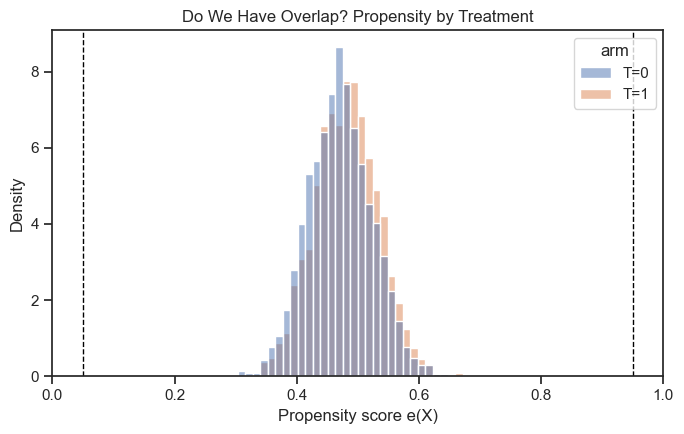

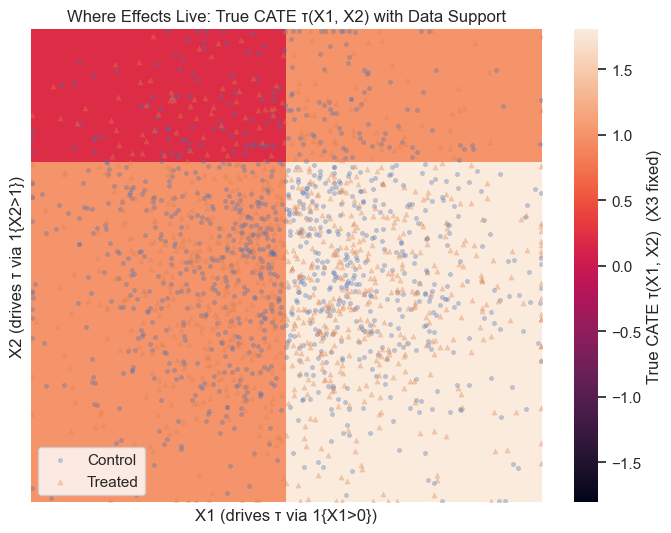

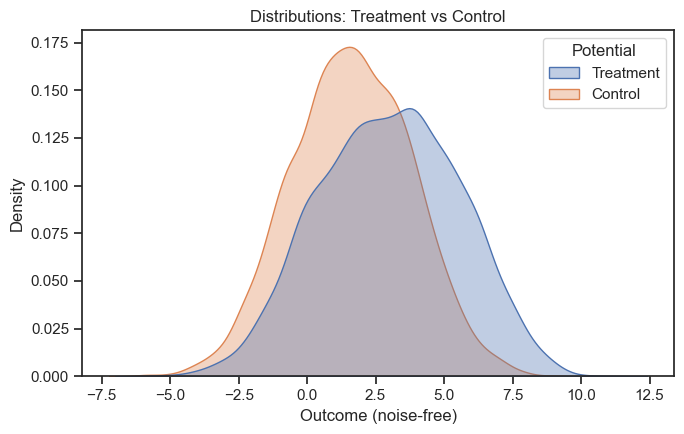

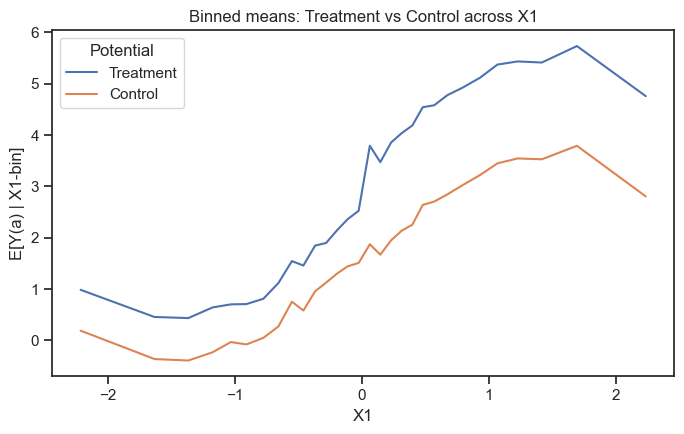

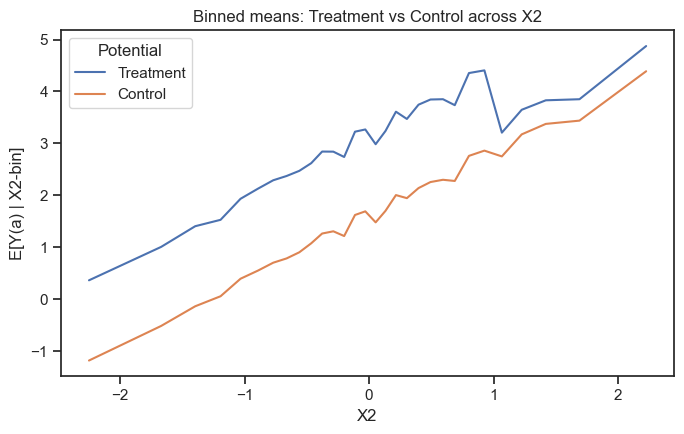

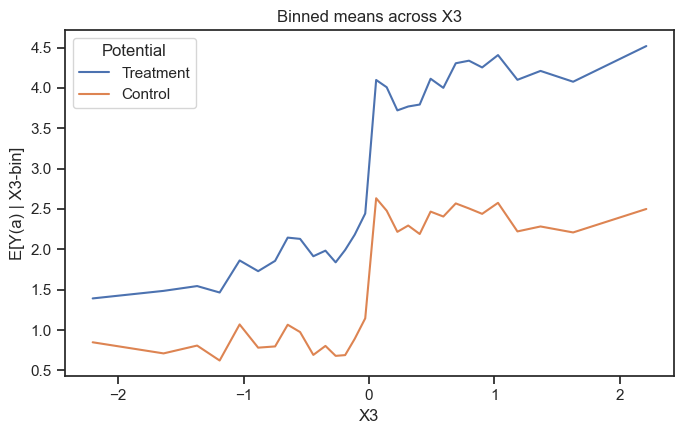

In [250]:
plot_overlap(df)                                  
plot_true_tau_heat(df, x3_fixed="median")    
plot_po_distrib(df)
plot_po_binned_vs_x(df, var="X1", nbins=30)
plot_po_binned_vs_x(df, var="X2", nbins=30)
plot_po_binned_vs_x(df, var="X3", nbins=30, title="Binned means across X3")


<blockquote style="font-size:0.8em; line-height:1.45;">
  <h3>Policy Example to understand the setting: Energy-Efficiency Retrofit Rebate</h3>
  <p><strong>Treatment:</strong> <em>A=1</em> if a household takes up the retrofit rebate (e.g., insulation, heat-pump subsidy).<br>
     <strong>Outcome:</strong> Annual energy consumption (kWh) or energy bill (EUR).</p>

  <h4>Baseline outcome (prognosis) μ(X)</h4>
  <p><em>Interpretation of the terms:</em></p>
  <ul>
    <li><strong>2·sin(X₁)</strong> — effect of climate zone / heating degree days.</li>
    <li><strong>1.25·X₂</strong> — roughly linear effect of income / dwelling size.</li>
    <li><strong>1.5·1{X₃&gt;0}</strong> — level shift for detached vs apartment.</li>
    <li><strong>0.75·X₄X₅</strong> — complementarity (poor insulation × large floor area).</li>
    <li><strong>|X₆|</strong> — distance from city center (either direction).</li>
  </ul>
  <p><em>Intuition:</em> μ(X) is large/complex. Naïve Y-prediction learners (S/T) mostly learn μ(X) rather than τ(X).</p>

  <h4>True treatment effect (CATE) τ(X)</h4>
  <ul>
    <li><strong>+1.12{X₁&gt;0}</strong> — bigger savings in colder climates.</li>
    <li><strong>−1.12{X₂&gt;1}</strong> — diminishing returns for high-income / efficient homes.</li>
    <li><strong>+sin(X₃/2)</strong> — smooth modulation by building form / suitability.</li>
  </ul>

  <h4>Assignment and overlap</h4>
  <p><strong>Imbalanced:</strong> e(x)=σ(−1+1.0X₁+0.8X₂+0.5X₇) — higher take-up among colder climates / higher-income / better-informed households.<br>
  <em>Implication:</em> self-selection creates weak-overlap regions; effect-targeted methods help.</p>
</blockquote>


## HTE Estimation: Naïve approach.

We will implement **S-** and **T-learners**, evaluate them against the true CATE, and give diagnostics that show why they fail (they chase prognosis/propensity).

#### Train and test data.

In [251]:
from sklearn.model_selection import train_test_split

def split_train_test(df, test_size=0.33, seed=123):
    cols_keep = [c for c in df.columns]  # keep all columns, we'll pick features later
    d = df[cols_keep].copy()
    return train_test_split(d, test_size=test_size, random_state=seed)

def get_X(df, feature_cols):
    return df[feature_cols].to_numpy()

#### Define S-learner and T-learner

In [253]:
# S-learner
def s_learner_tau(train_df, test_df, feature_cols, base=None):
    if base is None:
        base = GradientBoostingRegressor(random_state=1)
    Xtr = get_X(train_df, feature_cols)
    Atr = train_df["A"].to_numpy()
    Ytr = train_df["Y"].to_numpy()
    model = base
    # One model on (A, X)
    XA = np.c_[Atr, Xtr]
    model.fit(XA, Ytr)
    Xte = get_X(test_df, feature_cols)
    tau_hat = model.predict(np.c_[np.ones(len(Xte)), Xte]) - model.predict(np.c_[np.zeros(len(Xte)), Xte])
    return tau_hat

# T-learner 
def t_learner_tau(train_df, test_df, feature_cols, base_t=None, base_c=None):
    if base_t is None: base_t = GradientBoostingRegressor(random_state=2)
    if base_c is None: base_c = GradientBoostingRegressor(random_state=3)
    Xtr = get_X(train_df, feature_cols)
    Atr = train_df["A"].to_numpy().astype(bool)
    Ytr = train_df["Y"].to_numpy()
    Mt, Mc = base_t, base_c
    # Separate models by arm
    Mt.fit(Xtr[Atr], Ytr[Atr])
    Mc.fit(Xtr[~Atr], Ytr[~Atr])
    Xte = get_X(test_df, feature_cols)
    return Mt.predict(Xte) - Mc.predict(Xte)


#### Evaluation of results

In [254]:
# Evaluation: numbers + diagnostics that show mislearning 

# Use MISE
def baseline_test(test_df):
    tau = test_df["tau_true"].to_numpy()
    return float(((tau - tau.mean())**2).mean()), float(tau.mean())  # (MISE_baseline, tau_bar_test)

def eval_cate(test_df, tau_hat):
    tau = test_df["tau_true"].to_numpy(); 
    mu = test_df["mu_true"].to_numpy(); 
    e = test_df["e_true"].to_numpy()
    return float(mean_squared_error(tau, tau_hat)), float(tau_hat.mean()), float(np.corrcoef(tau_hat, mu)[0,1]), float(np.corrcoef(tau_hat, e)[0,1])


def calibration_df(test_df, tau_hat, q=10):
    """
    Decile calibration: bin by predicted CATE; compare predicted vs realized effect in each bin.
    If a bin has no treated or no controls, the realized effect is NaN.
    """
    d = test_df.copy()
    d["tau_hat"] = tau_hat
    d["bin"] = pd.qcut(d["tau_hat"], q=q, duplicates="drop")
    g = d.groupby("bin", observed=True)

    x = g["tau_hat"].mean()

    def realized(s):
        yt = s.loc[s.A == 1, "Y"]
        yc = s.loc[s.A == 0, "Y"]
        if len(yt) == 0 or len(yc) == 0:
            return np.nan
        return yt.mean() - yc.mean()

    y = g.apply(realized)
    out = pd.DataFrame({"pred_bin_mean": x.values, "realized_effect": y.values})
    return out

#### Visualization

In [255]:
sns.set_theme(context="notebook", style="ticks")

def plot_scatter_true_vs_hat(test_df, tau_hat, label="model", ax=None):
    """
    True vs Predicted CATE scatter with a 45° reference.
    """
    d = pd.DataFrame({
        "tau_true": test_df["tau_true"].to_numpy(),
        "tau_hat":  tau_hat
    })
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    sns.scatterplot(data=d, x="tau_true", y="tau_hat", s=10, alpha=0.4, ax=ax)
    lo = np.percentile(np.r_[d["tau_true"], d["tau_hat"]], 1)
    hi = np.percentile(np.r_[d["tau_true"], d["tau_hat"]], 99)
    ax.plot([lo, hi], [lo, hi], linestyle="--")
    ax.set_xlabel("True τ(x)")
    ax.set_ylabel("Predicted τ̂(x)")
    ax.set_title(f"True vs Predicted CATE — {label}")
    sns.despine()
    return ax

def plot_calibration(test_df, tau_hat, label="model", q=10, ax=None):
    """
    Calibration curve: bin-mean of predicted CATE (x) vs realized effect (y), with y=x reference.
    """
    cal = calibration_df(test_df, tau_hat, q=q)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    sns.lineplot(data=cal, x="pred_bin_mean", y="realized_effect", marker="o", ax=ax)
    # perfect calibration line
    xlo, xhi = cal["pred_bin_mean"].min(), cal["pred_bin_mean"].max()
    ax.plot([xlo, xhi], [xlo, xhi], linestyle="--")
    ax.set_xlabel("Predicted CATE (bin mean)")
    ax.set_ylabel("Realized effect in bin")
    ax.set_title(f"Calibration — {label}")
    sns.despine()
    return ax


### How Naïve models perform

We used only 7 features in the DGP: 3 are noise and used to create misspecified models.

In [256]:
# Feature sets
FEATURES_CORE = [f"X{i}" for i in range(1, 8)]   # X1..X7 (the ones used in DGP)
FEATURES_ALL  = [f"X{i}" for i in range(1, 11)]  # X1..X10 (adds irrelevant X8..X10)

In [257]:
train_df, test_df = split_train_test(df, test_size=0.33)

# Toggle here to show misspecification effect:
FEATURES = FEATURES_ALL    # try FEATURES_CORE vs FEATURES_ALL

# Fit learners
tau_s = s_learner_tau(train_df, test_df, FEATURES)
tau_t = t_learner_tau(train_df, test_df, FEATURES)

# Evaluate (MISE) + diagnostics
mise0, tau_bar = baseline_test(test_df)
mise_s, ate_s, c_mu_s, c_e_s = eval_cate(test_df, tau_s)
mise_t, ate_t, c_mu_t, c_e_t = eval_cate(test_df, tau_t)
pd.DataFrame([["Baseline (const τ)", mise0, tau_bar, tau_bar, None, None],
              ["S", mise_s, ate_s, tau_bar, c_mu_s, c_e_s],
              ["T", mise_t, ate_t, tau_bar, c_mu_t, c_e_t]],
             columns=["Model","MISE","ATE_hat","ATE_true","corr(τ_hat,μ)","corr(τ_hat,e)"]).round(4)



,Model,MISE,ATE_hat,ATE_true,"corr(τ_hat,μ)","corr(τ_hat,e)"
0,Baseline (const τ),0.6402,1.3629,1.3629,NaN,NaN
1,S,0.1429,1.2193,1.3629,0.3626,0.5653
2,T,0.2966,1.2964,1.3629,0.3053,0.4932


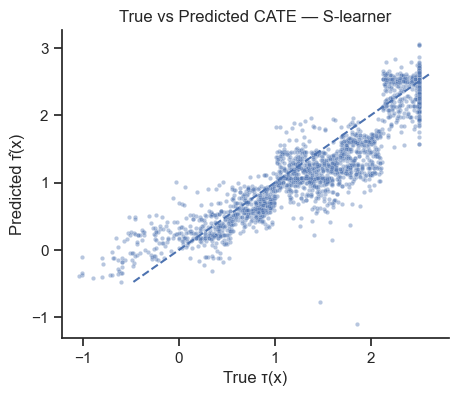

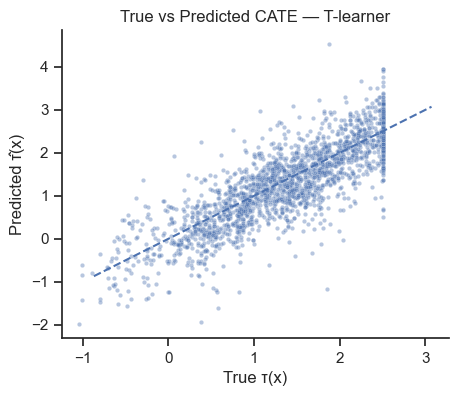

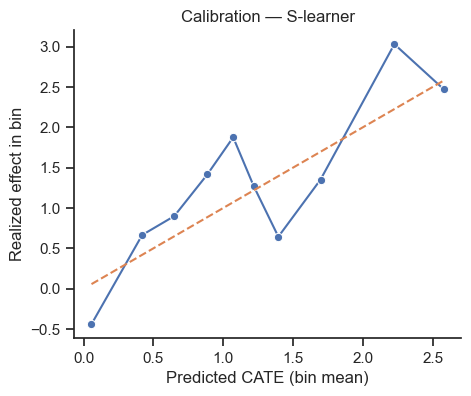

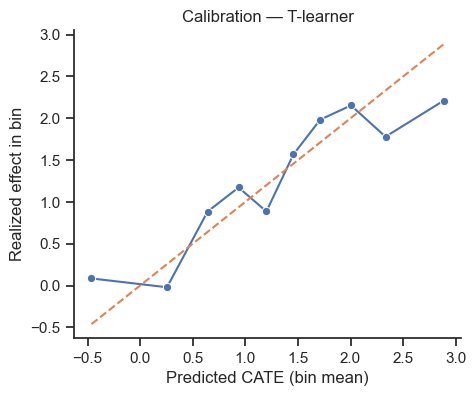

In [258]:
# --- PLOTS (drop NaN bins before plotting calibration) ---
plot_scatter_true_vs_hat(test_df, tau_s, "S-learner"); plt.show()
plot_scatter_true_vs_hat(test_df, tau_t, "T-learner"); plt.show()

cal_s = calibration_df(test_df, tau_s, q=10).dropna()
cal_t = calibration_df(test_df, tau_t, q=10).dropna()

plot_calibration(test_df.assign(), tau_s, "S-learner", q=10); plt.show()  
plot_calibration(test_df.assign(), tau_t, "T-learner", q=10); plt.show()  



**Summary**: Both S and T beat the “no-heterogeneity” baseline in global error (MISE: S = 0.1429, T = 0.2966 vs 0.6402), so they learn something beyond a constant effect. However, they are biased on the ATE (S: 1.2193 vs 1.3629; T: 1.2964 vs 1.3629) and, crucially, their predictions align strongly with prognosis and propensity rather than true heterogeneity (corr$(\hat{\tau}, \mu)$: S = 0.363, T = 0.305; corr$(\hat{\tau}, e)$: S = 0.565, T = 0.493). In short, naïve learners mostly chase $\mu(X)$ and $e(X)$, misranking who benefits; this motivates effect-targeted methods for CATE.

## HTE Estimation: Causal Forest.



NameError: name 'X' is not defined